In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

In [ ]:
api_token = {"username":"vbk1845","key":"62e251b17785a00dcf5e39fe66fc527e"}

In [ ]:
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 674M/675M [00:34<00:00, 20.9MB/s]
100% 675M/675M [00:34<00:00, 20.7MB/s]


In [ ]:
! mkdir dataset

In [ ]:
! unzip cell-images-for-detecting-malaria.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: dataset/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_221.png  
  inflating: dataset/cell_images/cell_im

In [ ]:
import os
path = "/content/dataset/cell_images/cell_images/"
path_data = os.listdir(path)

In [ ]:
path_data

['Parasitized', 'Uninfected']

In [ ]:
parasitized = os.listdir(path+path_data[0])
uninfected = os.listdir(path+path_data[1])

In [ ]:
parasitized.remove("Thumbs.db")
uninfected.remove("Thumbs.db")

In [ ]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/dataset/cell_images/cell_images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Using 5511 files for validation.


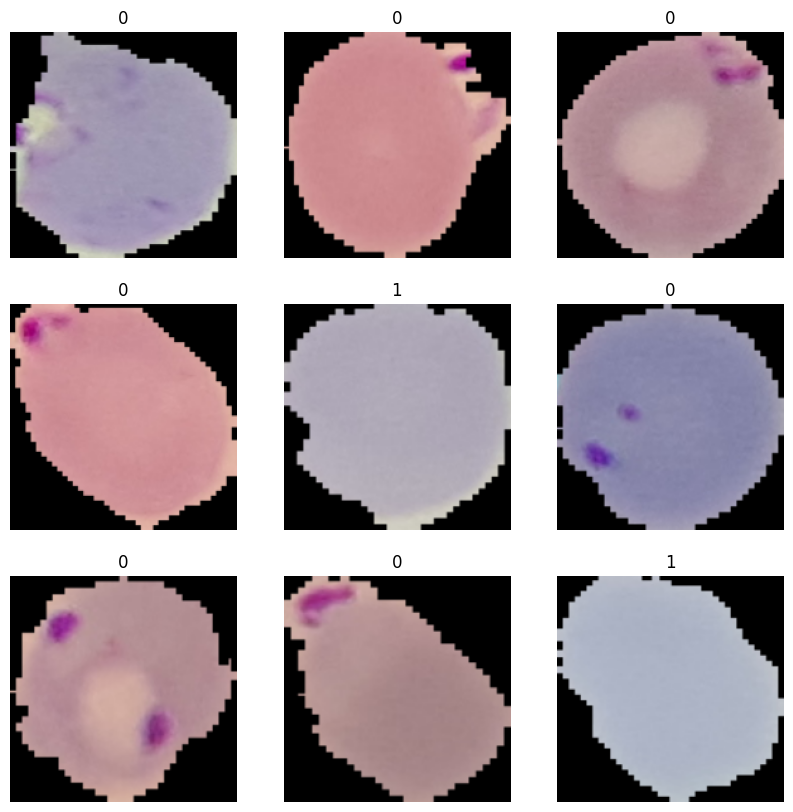

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
import os
import cv2
import numpy as np

# Create lists to store image data and labels
data = []
labels = []

# Define classes (folder names)
classes = ['Parasitized', 'Uninfected']

for class_name in classes:
    class_path = os.path.join('/content/dataset/cell_images/cell_images', class_name)
    for filename in os.listdir(class_path):
        if filename.endswith('.png'):  # Adjust the extension based on your dataset
            img = cv2.imread(os.path.join(class_path, filename))
            img = cv2.resize(img, (64, 64))  # Resize images to a common size
            data.append(img)
            labels.append(classes.index(class_name))

# Convert lists to NumPy arrays
data = np.array(data)
labels = np.array(labels)

In [ ]:
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

Data shape: (27558, 64, 64, 3)
Labels shape: (27558,)


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

# Normalize pixel values
data = data.astype('float32') / 255.0

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=len(classes))
y_test = to_categorical(y_test, num_classes=len(classes))

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# # Define an ImageDataGenerator for data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=40,  # Randomly rotate images by up to 40 degrees
#     width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
#     height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
#     shear_range=0.2,  # Apply shear transformations
#     zoom_range=0.2,  # Randomly zoom in by up to 20%
#     horizontal_flip=True,  # Randomly flip images horizontally
#     fill_mode='nearest'  # Fill in new pixels using the nearest available pixel
# )

# # Fit the datagen on your training data
# datagen.fit(X_train)

# # Create augmented data batches
# augmented_data = datagen.flow(X_train, y_train, batch_size=32)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(classes), activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# Train your model using augmented data
#history = model.fit(augmented_data, validation_data=(X_test, y_test), epochs=10)

Epoch 1/10
689/689 [==============================] - 7s 10ms/step - loss: 0.0675 - accuracy: 0.9761 - val_loss: 0.1430 - val_accuracy: 0.9550
Epoch 2/10
689/689 [==============================] - 5s 8ms/step - loss: 0.0582 - accuracy: 0.9795 - val_loss: 0.1829 - val_accuracy: 0.9545
Epoch 3/10
689/689 [==============================] - 5s 7ms/step - loss: 0.0492 - accuracy: 0.9825 - val_loss: 0.1552 - val_accuracy: 0.9557
Epoch 4/10
689/689 [==============================] - 5s 8ms/step - loss: 0.0462 - accuracy: 0.9840 - val_loss: 0.2008 - val_accuracy: 0.9530
Epoch 5/10
689/689 [==============================] - 5s 8ms/step - loss: 0.0409 - accuracy: 0.9854 - val_loss: 0.1879 - val_accuracy: 0.9490
Epoch 6/10
689/689 [==============================] - 5s 7ms/step - loss: 0.0368 - accuracy: 0.9871 - val_loss: 0.2389 - val_accuracy: 0.9505
Epoch 7/10
689/689 [==============================] - 6s 9ms/step - loss: 0.0284 - accuracy: 0.9899 - val_loss: 0.2692 - val_accuracy: 0.9516
Epoch

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy}")
train_accuracy = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {train_accuracy}")

173/173 [==============================] - 1s 4ms/step - loss: 0.3055 - accuracy: 0.9465
Test Accuracy: 0.946480393409729
689/689 [==============================] - 3s 5ms/step - loss: 0.0084 - accuracy: 0.9977
Train Accuracy: [0.008371137082576752, 0.9976866841316223]


In [ ]:
model.save('malaria_detection_model_rf.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
from keras.models import Model
from sklearn.ensemble import RandomForestClassifier

# Load your pre-trained CNN model
cnn_model = load_model('malaria_detection_model_rf.h5')  # Replace with your model filename

# Remove the output layer to use it as a feature extractor
cnn_feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

# Extract features from your training and testing data
cnn_features_train = cnn_feature_extractor.predict(X_train)
cnn_features_test = cnn_feature_extractor.predict(X_test)

173/173 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.decomposition import PCA

# Number of components to keep (you can adjust this)
n_components = 128

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit PCA to the CNN features from the training data
pca.fit(cnn_features_train)

# Transform the CNN features using PCA
pca_cnn_features_train = pca.transform(cnn_features_train)
pca_cnn_features_test = pca.transform(cnn_features_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Create a Random Forest classifier
rf_classifier_pca = RandomForestClassifier(n_estimators=108, random_state=0)

# Train the Random Forest classifier on the PCA features
rf_classifier_pca.fit(pca_cnn_features_train, y_train.argmax(axis=1))
rf_pca_train_predictions = rf_classifier_pca.predict(pca_cnn_features_train)

# Evaluate the Random Forest classifier with PCA features on the training set
rf_pca_train_accuracy = accuracy_score(y_train.argmax(axis=1), rf_pca_train_predictions)
print(f"Random Forest Classifier (PCA) Training Accuracy: {rf_pca_train_accuracy}")
# Predict using the Random Forest classifier
rf_pca_predictions = rf_classifier_pca.predict(pca_cnn_features_test)

# Evaluate the Random Forest classifier with PCA features
from sklearn.metrics import accuracy_score
rf_pca_accuracy = accuracy_score(y_test.argmax(axis=1), rf_pca_predictions)
print(f"Random Forest Classifier (PCA) Accuracy: {rf_pca_accuracy}")


Random Forest Classifier (PCA) Training Accuracy: 1.0
Random Forest Classifier (PCA) Accuracy: 0.9537373004354136


Confusion Matrix (Training Set):
 [[10982     0]
 [    0 11064]]
Confusion Matrix (Test Set):
 [[2657  140]
 [ 115 2600]]


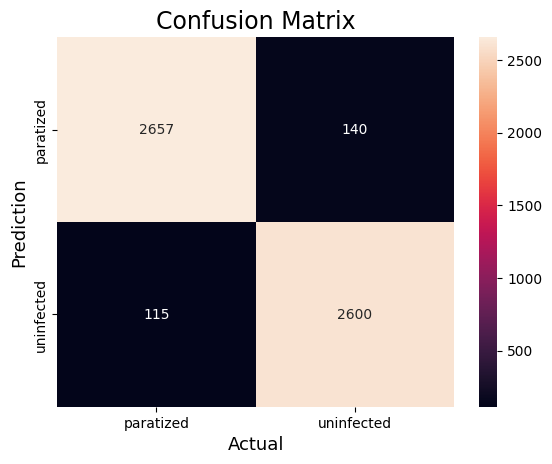

0.9537373004354136
The precision score is 0.948905109489051
Recall    : 0.9576427255985267
F1-score  : 0.9532538955087076


In [ ]:
# Calculate the confusion matrix for training set
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
confusion_matrix_train = confusion_matrix(y_train.argmax(axis=1), rf_pca_train_predictions)
print("Confusion Matrix (Training Set):\n", confusion_matrix_train)

# Calculate the confusion matrix for the test set
confusion_matrix_test = confusion_matrix(y_test.argmax(axis=1), rf_pca_predictions)
print("Confusion Matrix (Test Set):\n", confusion_matrix_test)

plt.show()

sns.heatmap(confusion_matrix_test,
            annot=True,
            fmt='g',
            xticklabels=['paratized', 'uninfected'],
            yticklabels=['paratized', 'uninfected'])
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

accuracy=accuracy_score(y_test.argmax(axis=1), rf_pca_predictions)
print(accuracy)
precision=precision_score(y_test.argmax(axis=1), rf_pca_predictions)
print("The precision score is",precision)
recall = recall_score(y_test.argmax(axis=1), rf_pca_predictions)
print("Recall    :", recall)
F1_score = f1_score(y_test.argmax(axis=1), rf_pca_predictions)
print("F1-score  :", F1_score)

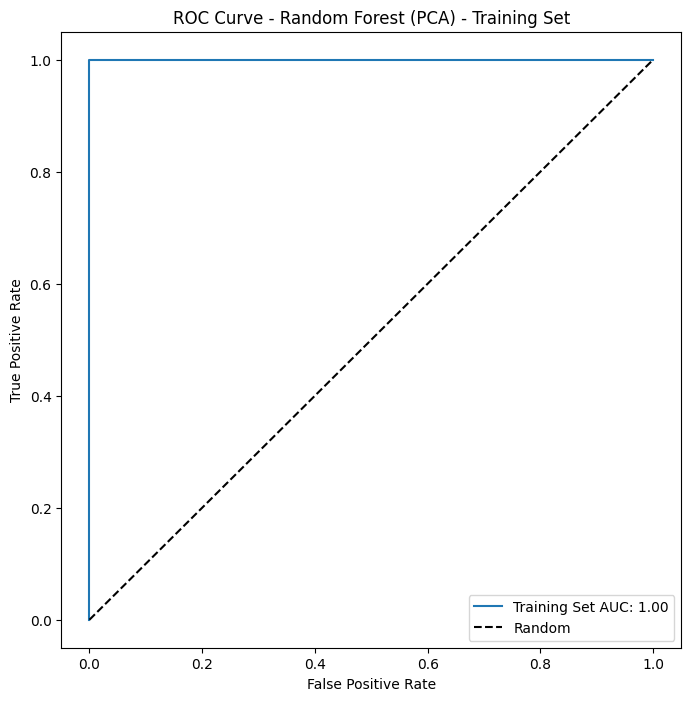

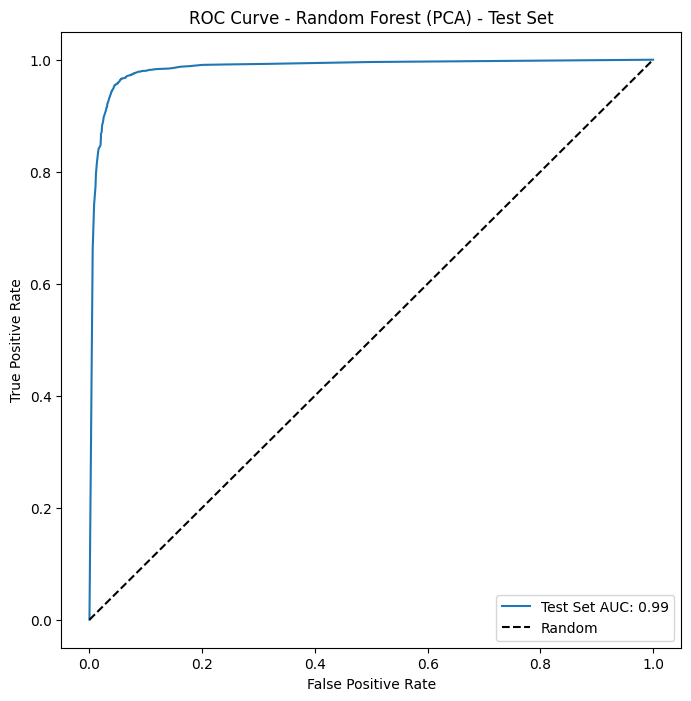

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ... (previous code)

# Train the Random Forest classifier on the PCA features
rf_classifier_pca.fit(pca_cnn_features_train, y_train.argmax(axis=1))
rf_pca_train_predictions = rf_classifier_pca.predict_proba(pca_cnn_features_train)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train.argmax(axis=1), rf_pca_train_predictions)

# Plot ROC curve for training set
plt.figure(figsize=(8, 8))
plt.plot(fpr_train, tpr_train, label=f'Training Set AUC: {auc(fpr_train, tpr_train):.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (PCA) - Training Set')
plt.legend(loc='lower right')
plt.show()

# Predict using the Random Forest classifier on the test set
rf_pca_predictions = rf_classifier_pca.predict_proba(pca_cnn_features_test)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_test, tpr_test, thresholds_test = roc_curve(y_test.argmax(axis=1), rf_pca_predictions)

# Plot ROC curve for test set
plt.figure(figsize=(8, 8))
plt.plot(fpr_test, tpr_test, label=f'Test Set AUC: {auc(fpr_test, tpr_test):.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (PCA) - Test Set')
plt.legend(loc='lower right')
plt.show()


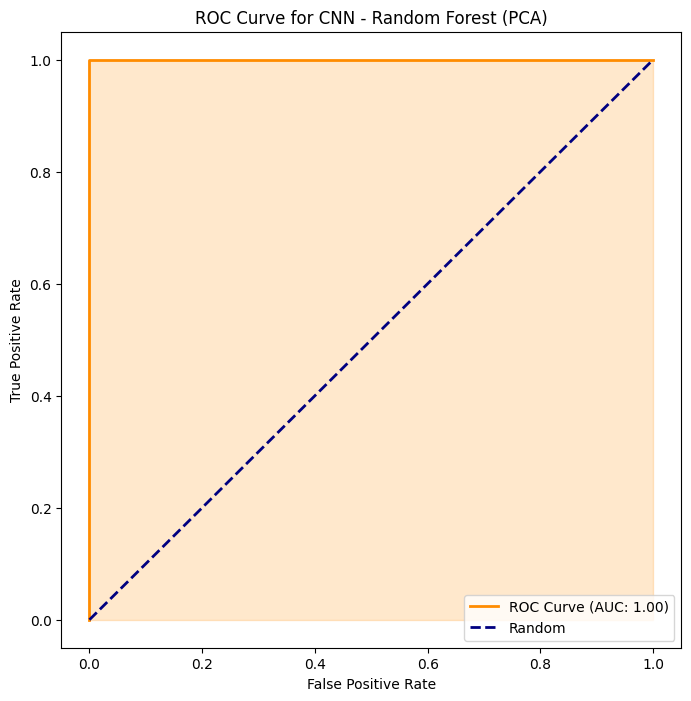

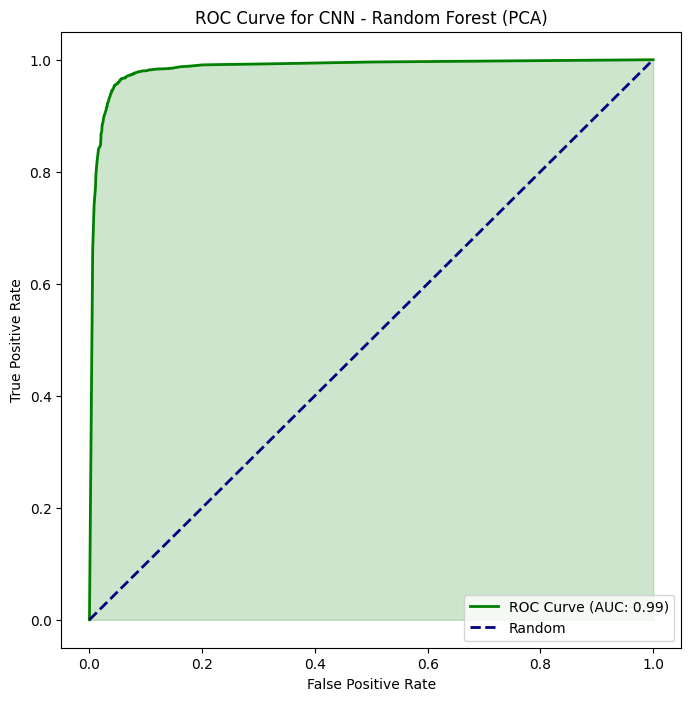

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ... (previous code)

# Train the Random Forest classifier on the PCA features
rf_classifier_pca.fit(pca_cnn_features_train, y_train.argmax(axis=1))
rf_pca_train_predictions = rf_classifier_pca.predict_proba(pca_cnn_features_train)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train.argmax(axis=1), rf_pca_train_predictions)

# Plot ROC curve for training set with different color and area under the curve
plt.figure(figsize=(8, 8))
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Curve (AUC: {roc_auc_train:.2f})')
plt.fill_between(fpr_train, tpr_train, alpha=0.2, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN - Random Forest (PCA)')
plt.legend(loc='lower right')
plt.show()

# Predict using the Random Forest classifier on the test set
rf_pca_predictions = rf_classifier_pca.predict_proba(pca_cnn_features_test)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_test, tpr_test, thresholds_test = roc_curve(y_test.argmax(axis=1), rf_pca_predictions)

# Plot ROC curve for test set with different color and area under the curve
plt.figure(figsize=(8, 8))
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'ROC Curve (AUC: {roc_auc_test:.2f})')
plt.fill_between(fpr_test, tpr_test, alpha=0.2, color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN - Random Forest (PCA)')
plt.legend(loc='lower right')
plt.show()


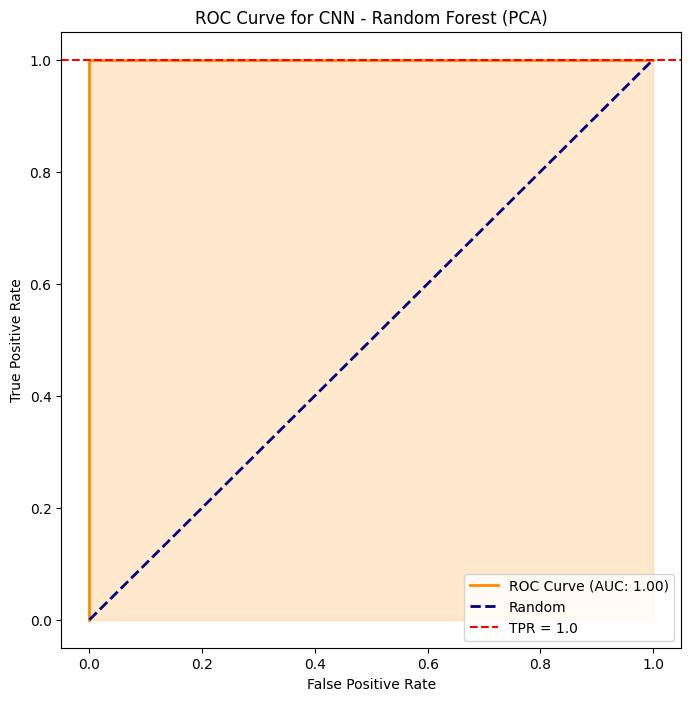

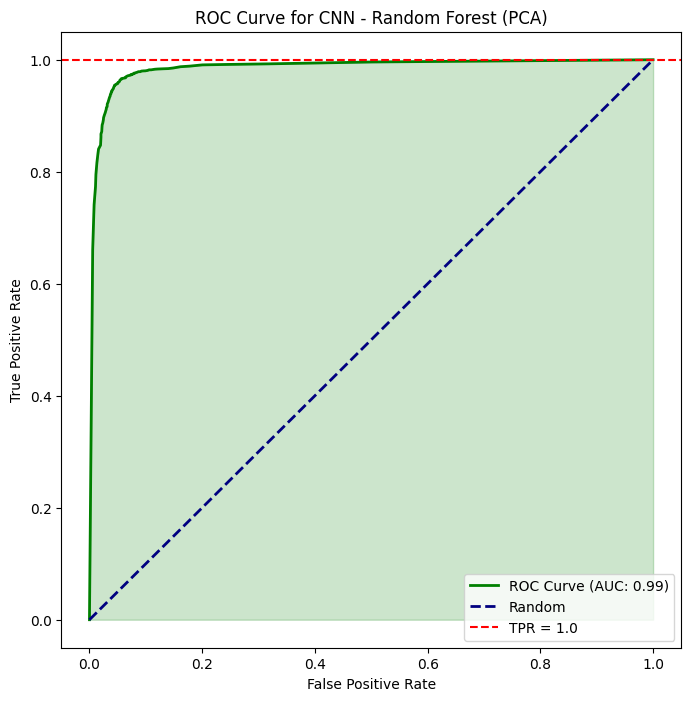

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ... (previous code)

# Train the Random Forest classifier on the PCA features
rf_classifier_pca.fit(pca_cnn_features_train, y_train.argmax(axis=1))
rf_pca_train_predictions = rf_classifier_pca.predict_proba(pca_cnn_features_train)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_train, tpr_train, thresholds_train = roc_curve(y_train.argmax(axis=1), rf_pca_train_predictions)

# Plot ROC curve for training set with different color and area under the curve
plt.figure(figsize=(8, 8))
roc_auc_train = auc(fpr_train, tpr_train)
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC Curve (AUC: {roc_auc_train:.2f})')
plt.fill_between(fpr_train, tpr_train, alpha=0.2, color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.axhline(y=1, color='red', linestyle='--', label='TPR = 1.0')  # Add line at TPR = 1.0
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN - Random Forest (PCA)')
plt.legend(loc='lower right')
plt.show()

# Predict using the Random Forest classifier on the test set
rf_pca_predictions = rf_classifier_pca.predict_proba(pca_cnn_features_test)[:, 1]

# Get the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr_test, tpr_test, thresholds_test = roc_curve(y_test.argmax(axis=1), rf_pca_predictions)

# Plot ROC curve for test set with different color and area under the curve
plt.figure(figsize=(8, 8))
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'ROC Curve (AUC: {roc_auc_test:.2f})')
plt.fill_between(fpr_test, tpr_test, alpha=0.2, color='green')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.axhline(y=1, color='red', linestyle='--', label='TPR = 1.0')  # Add line at TPR = 1.0
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CNN - Random Forest (PCA)')
plt.legend(loc='lower right')
plt.show()


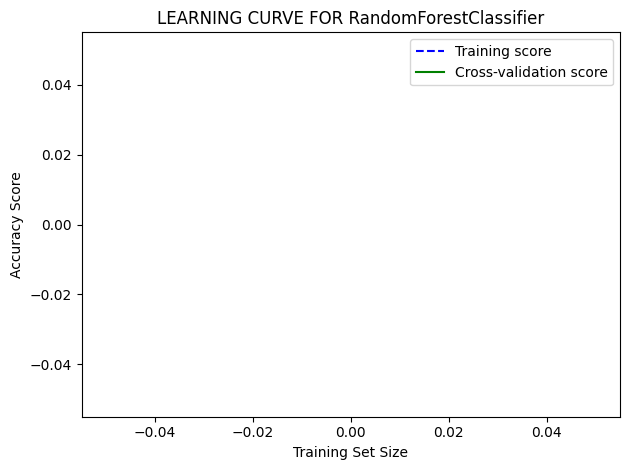

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import learning_curve
sizes, training_scores, testing_scores = learning_curve(RandomForestClassifier(), data, labels, cv=10, scoring='accuracy', train_sizes=np.linspace(0.01, 1.0, 50))
mean_training = np.mean(training_scores, axis=1)
Standard_Deviation_training = np.std(training_scores, axis=1)
mean_testing = np.mean(testing_scores, axis=1)
Standard_Deviation_testing = np.std(testing_scores, axis=1)
plt.plot(sizes, mean_training, '--', color="b",  label="Training score")
plt.plot(sizes, mean_testing, color="g", label="Cross-validation score")
plt.title("LEARNING CURVE FOR RandomForestClassifier")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.datasets import mnist
from keras.utils import to_categorical
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Load the MNIST dataset as an example (replace with your malaria dataset)
X = data
y = labels

# Normalize and preprocess data (reshape, one-hot encoding)
X = X / 255.0
X = X.reshape(X.shape[0], 64, 64, 3)
y = to_categorical(y, num_classes=len(classes))

# Initialize lists to store performance metrics
train_accuracies = []
val_accuracies = []

# Define the range of training dataset sizes (10% to 100%)
training_sizes = np.arange(0.1, 1.1, 0.1)

for training_size in training_sizes:
    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=training_size, random_state=42)

    # Define and train your CNN model (replace with your CNN model code)
    model = Sequential()
    # ... Define CNN layers and compile model
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(classes), activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=5)

    # Extract features using your CNN model
    cnn_features_train = model.predict(X_train)
    cnn_features_val = model.predict(X_val)

    # Train the Random Forest on the CNN-extracted features
    rf_classifier = RandomForestClassifier(n_estimators=108, random_state=0)
    rf_classifier.fit(cnn_features_train, y_train.argmax(axis=1))

    # Make predictions and evaluate on the validation set
    y_train_pred = rf_classifier.predict(cnn_features_train)
    y_val_pred = rf_classifier.predict(cnn_features_val)

    train_accuracy = accuracy_score(y_train.argmax(axis=1), y_train_pred)
    val_accuracy = accuracy_score(y_val.argmax(axis=1), y_val_pred)

    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1/10
87/87 [==============================] - 12s 9ms/step - loss: 0.6402 - accuracy: 0.6290
Epoch 2/10
87/87 [==============================] - 1s 8ms/step - loss: 0.4595 - accuracy: 0.8145
Epoch 3/10
87/87 [==============================] - 1s 7ms/step - loss: 0.2315 - accuracy: 0.9122
Epoch 4/10
87/87 [==============================] - 1s 8ms/step - loss: 0.1965 - accuracy: 0.9358
Epoch 5/10
87/87 [==============================] - 1s 8ms/step - loss: 0.1475 - accuracy: 0.9525
Epoch 6/10
87/87 [==============================] - 1s 8ms/step - loss: 0.1453 - accuracy: 0.9532
Epoch 7/10
87/87 [==============================] - 1s 8ms/step - loss: 0.1256 - accuracy: 0.9659
Epoch 8/10
87/87 [==============================] - 1s 7ms/step - loss: 0.1127 - accuracy: 0.9681
Epoch 9/10
87/87 [==============================] - 1s 6ms/step - loss: 0.0963 - accuracy: 0.9706
Epoch 10/10
87/87 [==============================] - 0s 3ms/step
